In [1]:
import scvelo as scv
import cellrank as cr
import scanpy as sc
import pandas as pd
import pickle
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo',dpi_save=600,dpi=50)  # for beautified visualization
palette=["#8DD3C7","#FFFFB3","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69","#FCCDE5","#D9D9D9"]

In [2]:
clusters=pd.read_csv("data/clusters_all.csv",index_col=0)

In [3]:
!wget -O - https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4859nnn/GSM4859875/suppl/GSM4859875_05pka_velo.loom.gz | gunzip -c > 05pka_velo.loom

--2023-03-30 09:40:38--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4859nnn/GSM4859875/suppl/GSM4859875_05pka_velo.loom.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 165.112.9.230, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50326667 (48M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]  48,00M  8,42MB/s    in 8,4s    

2023-03-30 09:40:47 (5,71 MB/s) - written to stdout [50326667/50326667]



In [4]:
!wget -O - https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4859nnn/GSM4859876/suppl/GSM4859876_100pka_velo.loom.gz | gunzip -c > 100pka_velo.loom

--2023-03-30 09:40:47--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4859nnn/GSM4859876/suppl/GSM4859876_100pka_velo.loom.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.7, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55379984 (53M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]  52,81M  9,50MB/s    in 6,9s    

2023-03-30 09:40:55 (7,64 MB/s) - written to stdout [55379984/55379984]



/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
Filtered out 46300 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)
or disable the progress bar using `show_progress_bar=False`.


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


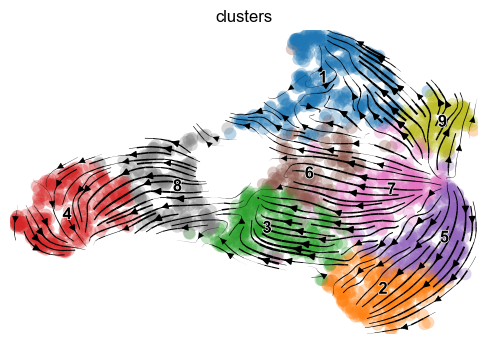

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap2', embedded velocity vectors (adata.obsm)


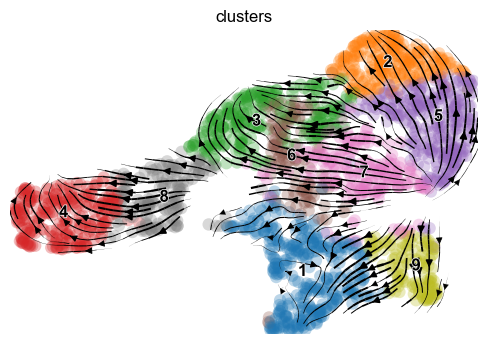

In [5]:
adata=scv.read("100pka_velo.loom",cache=True)
adata.obs.index=(map(lambda y: "hard_"+y.split("x")[0]+"-1",map(lambda x: x.split(":")[1],adata.obs.index)))
umap=pd.read_csv("data/UMAP_100pka.csv",index_col=0)
adata=adata[umap.index,:]
adata.obsm["X_umap"]=umap.values
adata_hard=adata
adata.obs['clusters']=clusters["x"].values[clusters.index.str.contains("hard")]
adata.var_names_make_unique()
scv.tl.score_genes_cell_cycle(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap')
umap2=pd.read_csv("data/UMAP_100pka_2.csv",index_col=0)
umap2.index=(map(lambda x: x.split("_")[1],umap2.index))
adata.obsm["X_umap2"]=umap2.values
scv.pl.velocity_embedding_stream(adata, basis='umap2')

saving figure to file ./figures/scvelo_hard_umap_cc.png


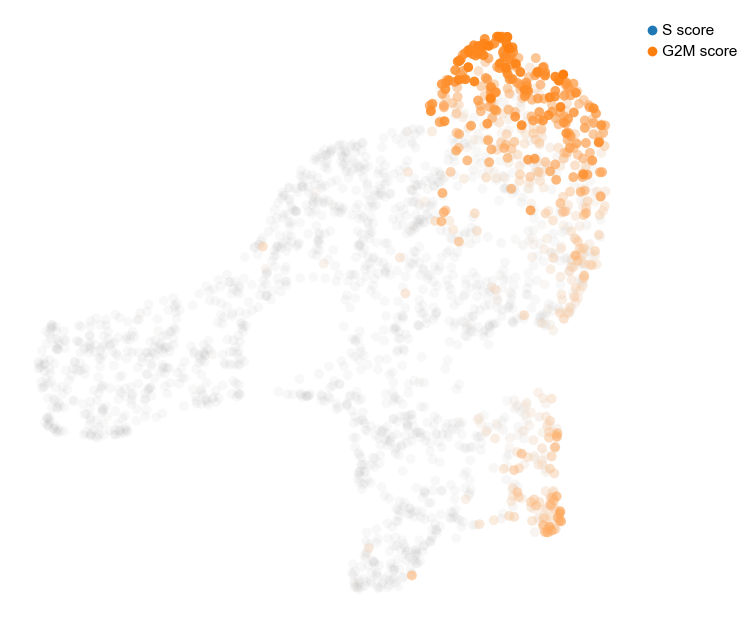

In [6]:
scv.pl.scatter(adata,basis="umap2", color_gradients=['S_score', 'G2M_score'], size=200,smooth=True, perc=[5, 95],fontsize=18,figsize=[8,8],save="hard_umap_cc.png")

In [7]:
scv.tl.recover_dynamics(adata,n_jobs=44)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics (using 44/88 cores)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:20) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap2', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_hard_umap_stream.png


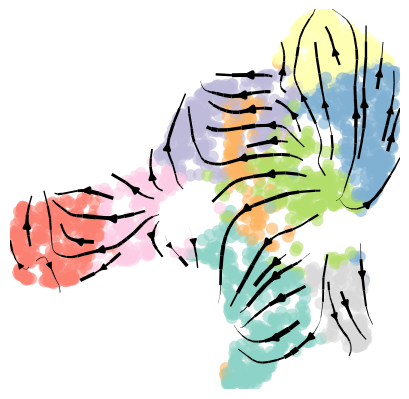

In [8]:
scv.pl.velocity_embedding_stream(adata, basis='umap2',title="",linewidth=2,alpha=.6,density=.8,
                                 figsize=[5,5],palette=palette,legend_loc="none",save="hard_umap_stream.png")

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file ./figures/scvelo_hard_umap_latent_dyn.png


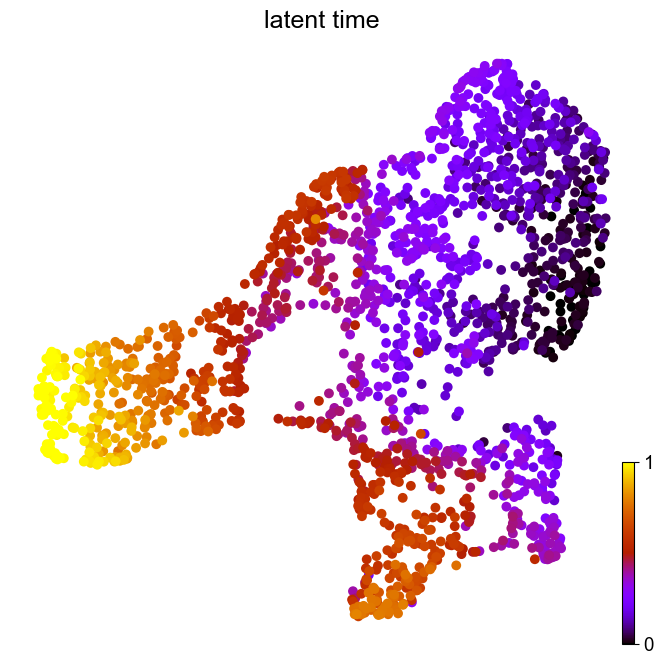

In [9]:
scv.tl.recover_latent_time(adata)

scv.pl.scatter(adata, basis='umap2',color='latent_time', fontsize=18, size=200,figsize=[8,8],
               color_map='gnuplot', perc=[2, 98], colorbar=True, rescale_color=[0,1],save="hard_umap_latent_dyn.png")

<Axes: xlabel='fit_likelihood', ylabel='Density'>

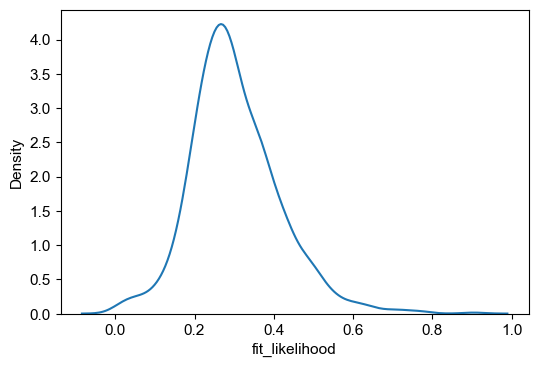

In [10]:
import seaborn as sns
sns.kdeplot(adata.var["fit_likelihood"])

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap2', embedded velocity vectors (adata.obsm)


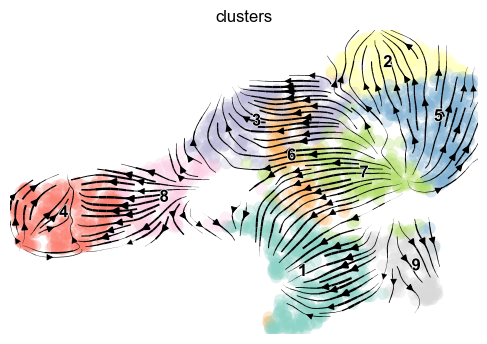

In [11]:
adata=adata[:,adata.var["fit_likelihood"]>.4]
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, basis='umap2')
scv.pl.velocity_embedding_stream(adata, basis='umap2')

In [12]:
adata

AnnData object with n_obs × n_vars = 2006 × 166
    obs: 'clusters', 'S_score', 'G2M_score', 'phase', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'clusters_gradients', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'clusters_colors', 'clusters_gradients_colors', 'recover_dynamics'
    obsm: 'X_umap', 'X_pca', 'velocity_umap', 'X_umap2', 'velocity_umap2'
    varm: 'PCs', 'loss'
    la

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


saving figure to file ./figures/scvelo_hard_8_3_bridge.png


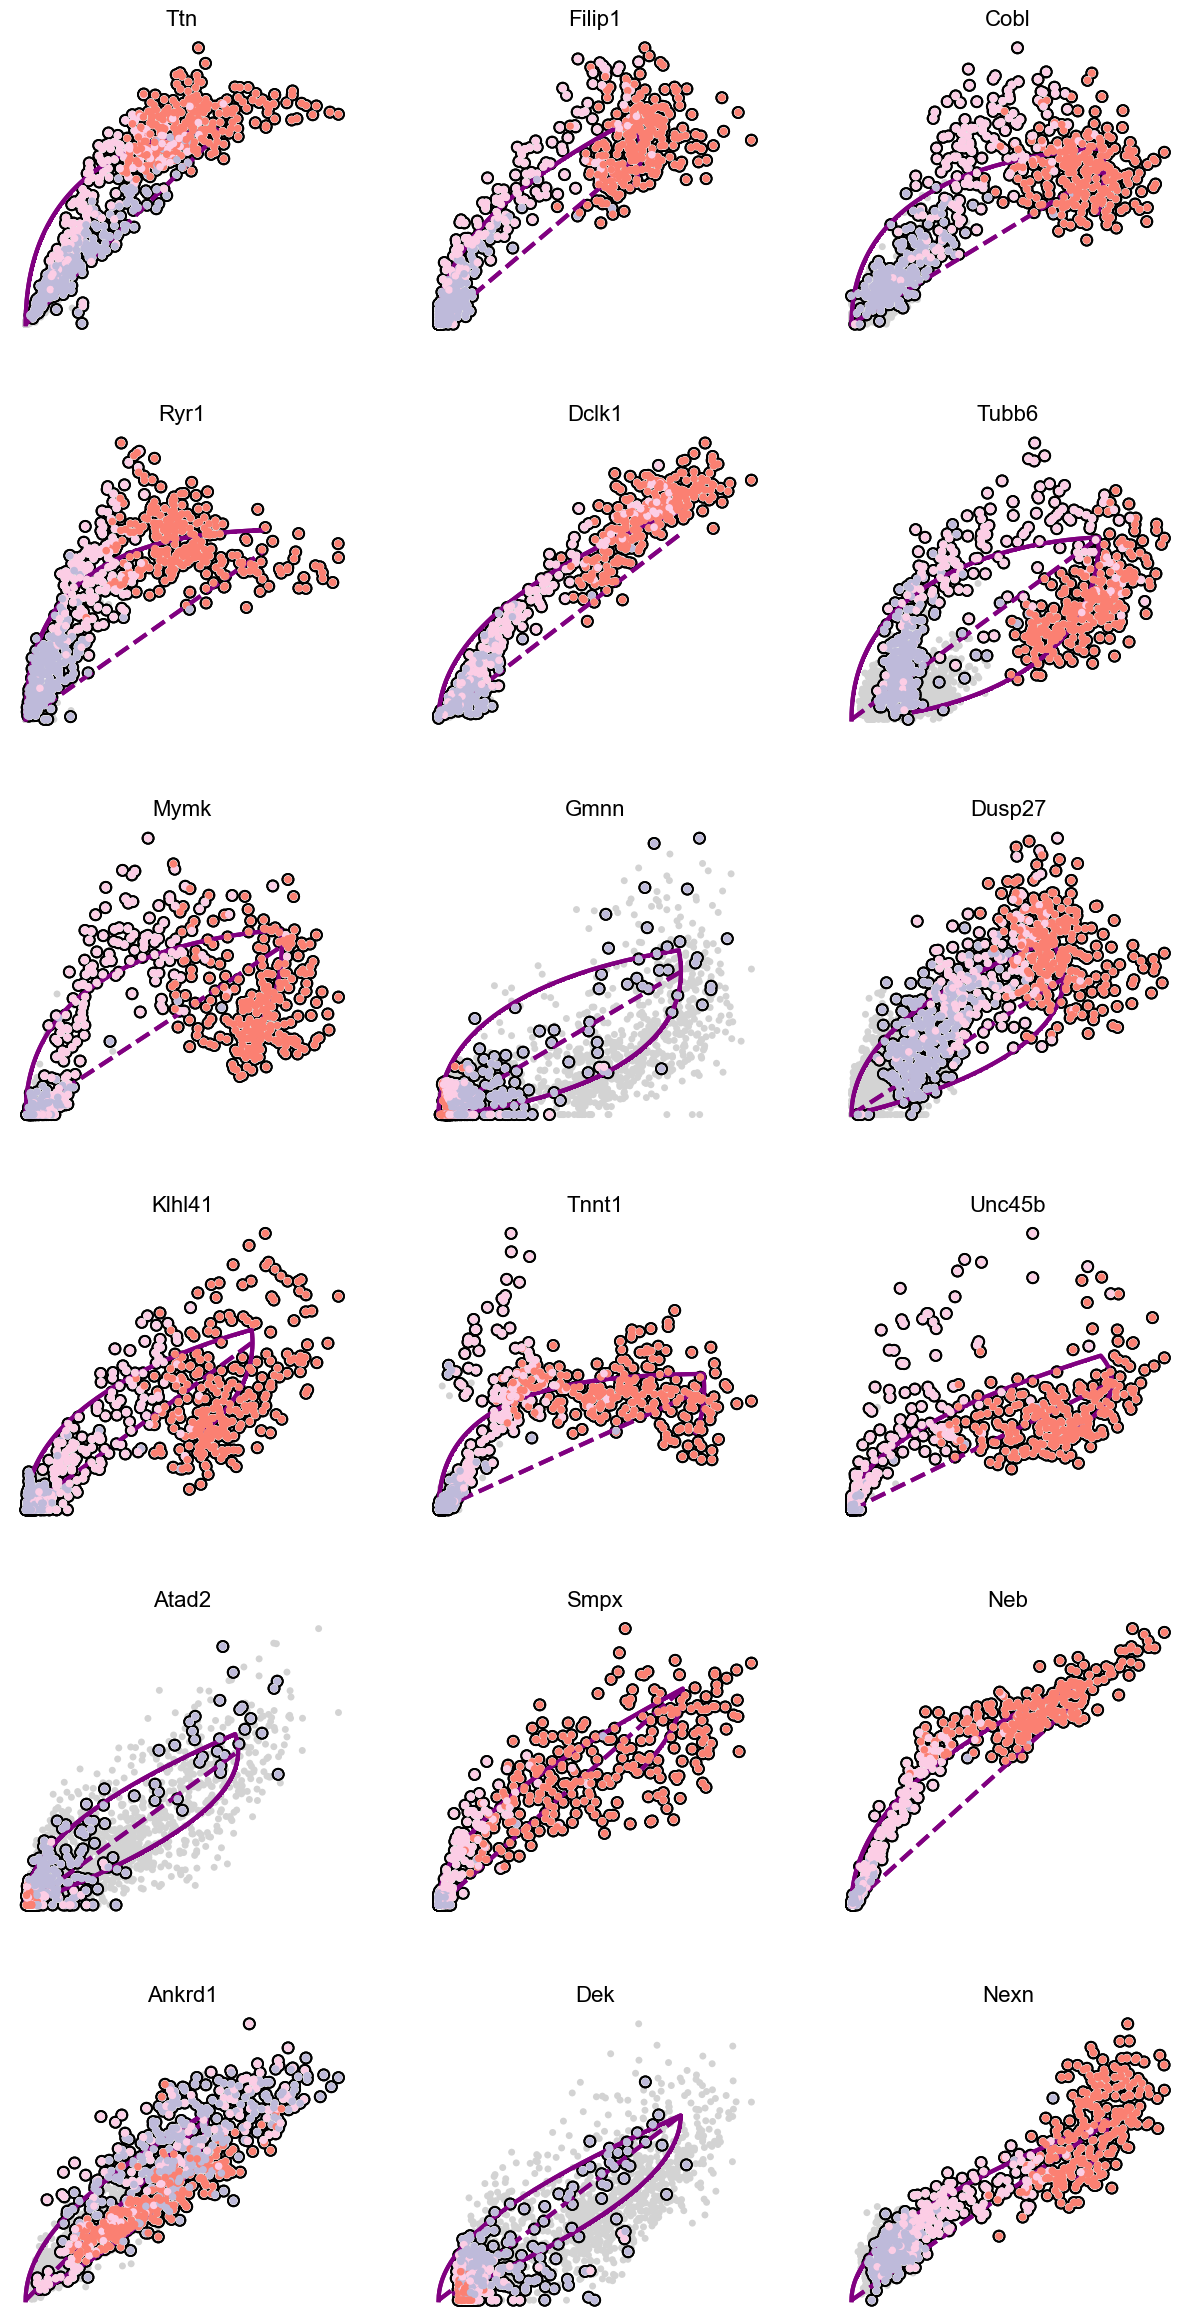

saving figure to file ./figures/scvelo_hard_8_1_bridge.png


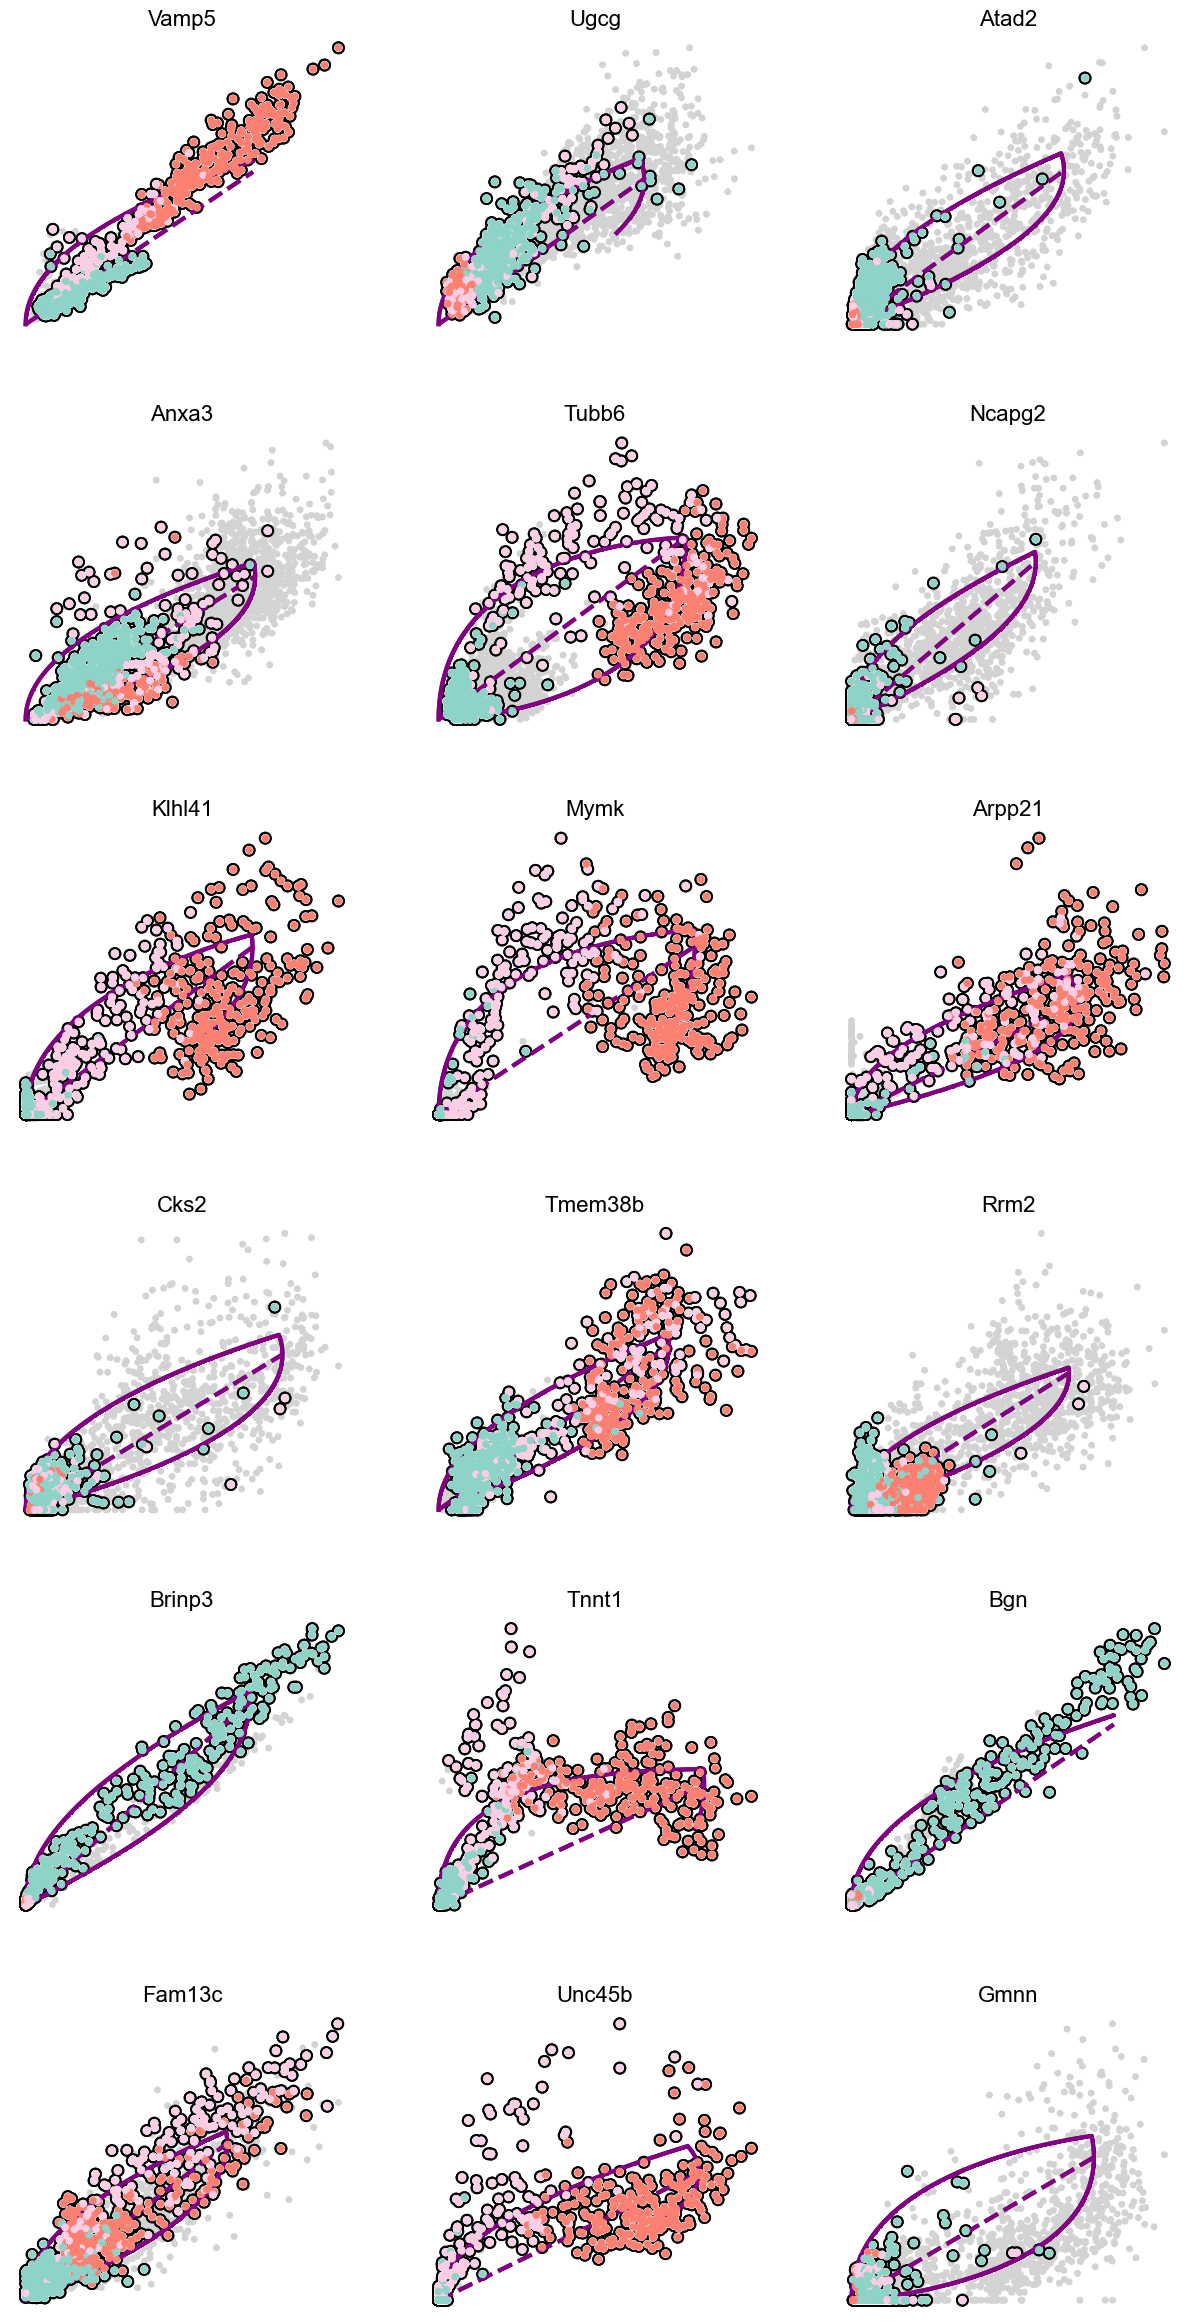

In [13]:
scv.settings.set_figure_params('scvelo',dpi=50)
adata.obs["mesenchyme_bridge"]=adata.obs["clusters"].isin(["8","1"])
scv.tl.rank_velocity_genes(adata, groupby="mesenchyme_bridge",n_genes=18)
mesenchyme_bridge=pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
adata.obs["cycling_bridge"]=adata.obs["clusters"].isin(["8","3"])
scv.tl.rank_velocity_genes(adata, groupby="cycling_bridge",n_genes=18)
cycling_bridge=pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
scv.pl.scatter(adata, basis=cycling_bridge["True"].values.tolist(), fontsize=16, size=100, linewidth=3,color="clusters",
               frameon=False, figsize=[5,5],legend_loc='none',ncols=3,groups=["3","8","4"],add_outline='3, 8,4',save="hard_8_3_bridge.png")

scv.pl.scatter(adata, basis=mesenchyme_bridge["True"].values.tolist(), fontsize=16, size=100, linewidth=3,color="clusters",
               frameon=False, figsize=[5,5],legend_loc='none',ncols=3,groups=["1","8","4"],add_outline='1, 8,4',save="hard_8_1_bridge.png")

saving figure to file ./figures/scvelo_hard_8_3_bridge_markers.png


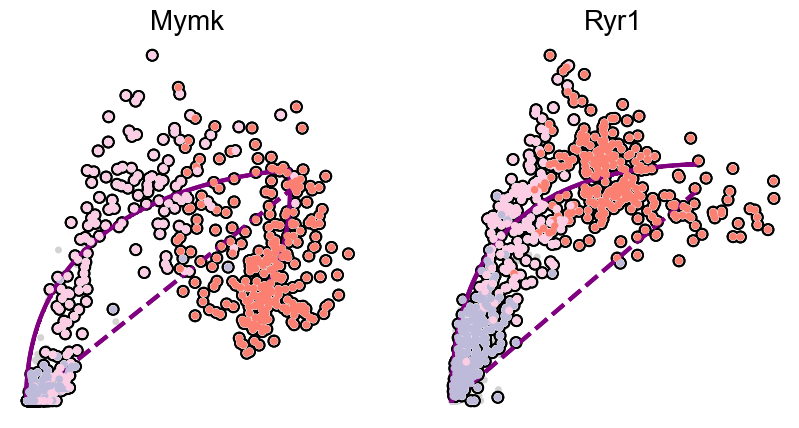

In [14]:
scv.pl.scatter(adata, basis=["Myl1","Srl","Mymk","Ryr1"], fontsize=20, size=100, linewidth=3,color="clusters",
               frameon=False, figsize=[5,5],legend_loc='none',ncols=2,groups=["3","8","4"],add_outline='3, 8,4',save="hard_8_3_bridge_markers.png")

In [16]:
adata.obs.mesenchyme_bridge=adata.obs.mesenchyme_bridge.astype(str)
adata.obs.cycling_bridge=adata.obs.cycling_bridge.astype(str)

In [17]:
adata.write_h5ad("adata_hard.h5ad")

/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


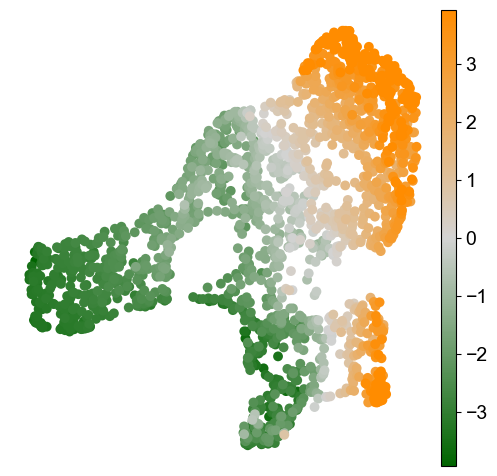

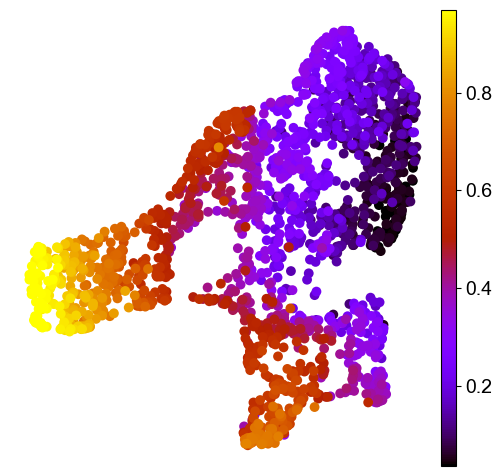

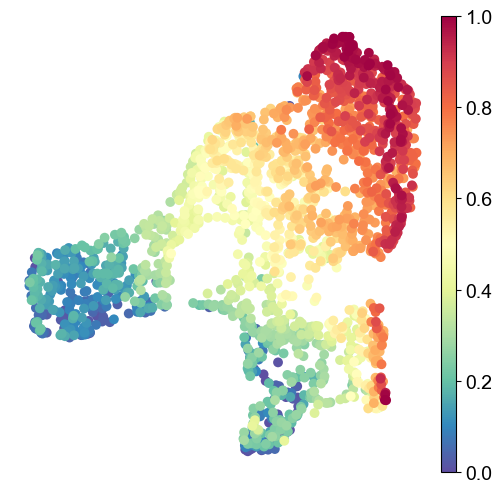

In [18]:
aspects=pd.read_csv("data/aspects_2_3.csv",index_col=0)
adata.obs["aspect"]=aspects.loc[adata.obs_names,"aspect3"]
adata.obs["CytoTRACE"]=pd.read_table("data/100pkaCytoTRACE_plot_table.txt")["CytoTRACE"]
from matplotlib.colors import LinearSegmentedColormap
cm=LinearSegmentedColormap.from_list("cm",["darkgreen","lightgrey","darkorange"])
import numpy as np
v=np.min([adata.obs.aspect.abs().max(),-adata.obs.aspect.min()])
adata.obsm["X_umap"]=adata.obsm["X_umap2"]
sc.set_figure_params(figsize=(6,6),dpi_save=600,dpi=50,frameon=False)
sc.pl.umap(adata,color="aspect",size=200,color_map=cm,vmin=-v,vmax=v,save="_hard_cc_aspect.png",title="")
sc.pl.umap(adata,color='latent_time', size=200,vmin="p2",vmax="p98", color_map='gnuplot',save="_hard_latent_time.png",title="")
sc.pl.umap(adata,color='CytoTRACE', size=200,color_map='Spectral_r',save="_hard_CytoTRACE.png",title="")

/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
Filtered out 46441 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


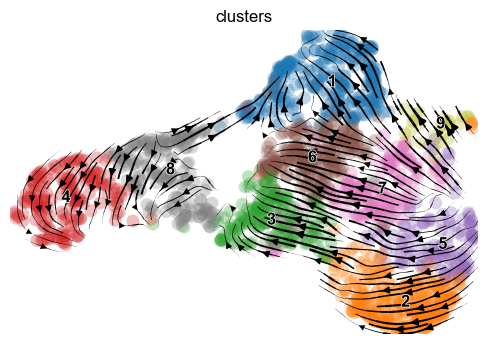

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap2', embedded velocity vectors (adata.obsm)


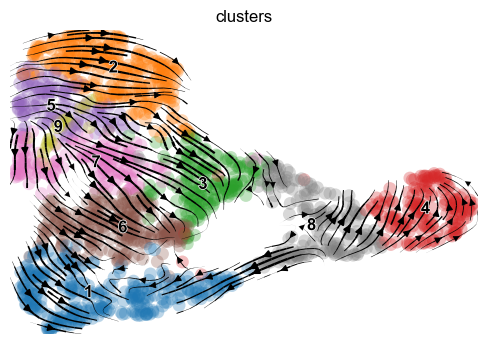

In [20]:
scv.settings.set_figure_params('scvelo',dpi_save=600,dpi=50)
adata=scv.read("05pka_velo.loom",cache=True)
adata.obs.index=(map(lambda y: "soft_"+y.split("x")[0]+"-1",map(lambda x: x.split(":")[1],adata.obs.index)))
umap=pd.read_csv("data/UMAP_05pka.csv",index_col=0)
adata=adata[umap.index,:]
adata.obsm["X_umap"]=umap.values
adata_soft=adata
#clusters=pd.read_csv("_Velo/clusters_05pka.csv",index_col=0)
adata.obs['clusters']=clusters["x"].values[clusters.index.str.contains("soft")]
adata.var_names_make_unique()
scv.tl.score_genes_cell_cycle(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap')
umap2=pd.read_csv("data/UMAP_05pka_2.csv",index_col=0)
umap2.index=(map(lambda x: x.split("_")[1],umap2.index))
adata.obsm["X_umap2"]=umap2.values
scv.pl.velocity_embedding_stream(adata, basis='umap2')

In [21]:
scv.tl.recover_dynamics(adata,n_jobs=44)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics (using 44/88 cores)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:14) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap2', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_soft_umap_stream_dyn.png


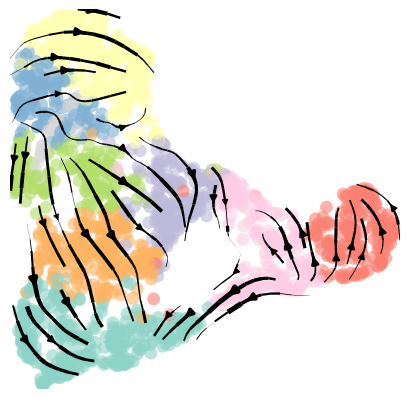

In [22]:
scv.pl.velocity_embedding_stream(adata, basis='umap2',title="",linewidth=2,alpha=.6,density=.8,
                                 figsize=[5,5],palette=palette,legend_loc="none",save="soft_umap_stream_dyn.png")

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file ./figures/scvelo_soft_umap_latent_dyn.png


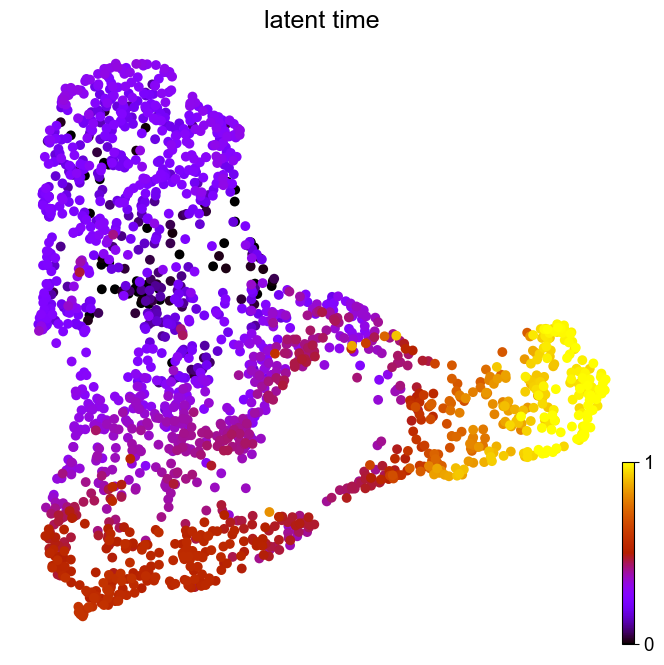

In [23]:
scv.tl.terminal_states(adata)
scv.tl.recover_latent_time(adata)
scv.pl.scatter(adata, basis='umap2',color='latent_time', fontsize=18, size=200,figsize=[8,8],
               color_map='gnuplot', perc=[2, 98], colorbar=True, rescale_color=[0,1],save="soft_umap_latent_dyn.png")

<Axes: xlabel='fit_likelihood', ylabel='Density'>

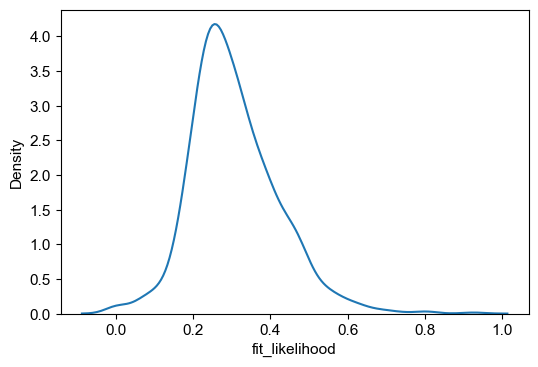

In [24]:
import seaborn as sns
sns.kdeplot(adata.var["fit_likelihood"])

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap2', embedded velocity vectors (adata.obsm)


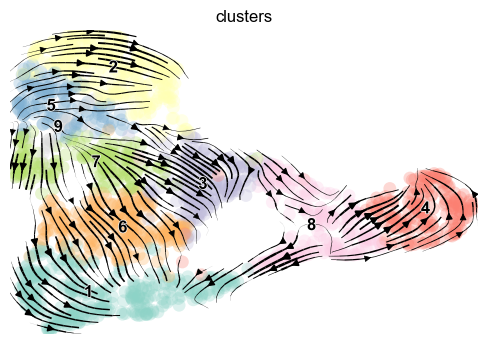

In [25]:
adata=adata[:,adata.var["fit_likelihood"]>.4]
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, basis='umap2')
scv.pl.velocity_embedding_stream(adata, basis='umap2')


ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


saving figure to file ./figures/scvelo_soft_8_3_bridge.png


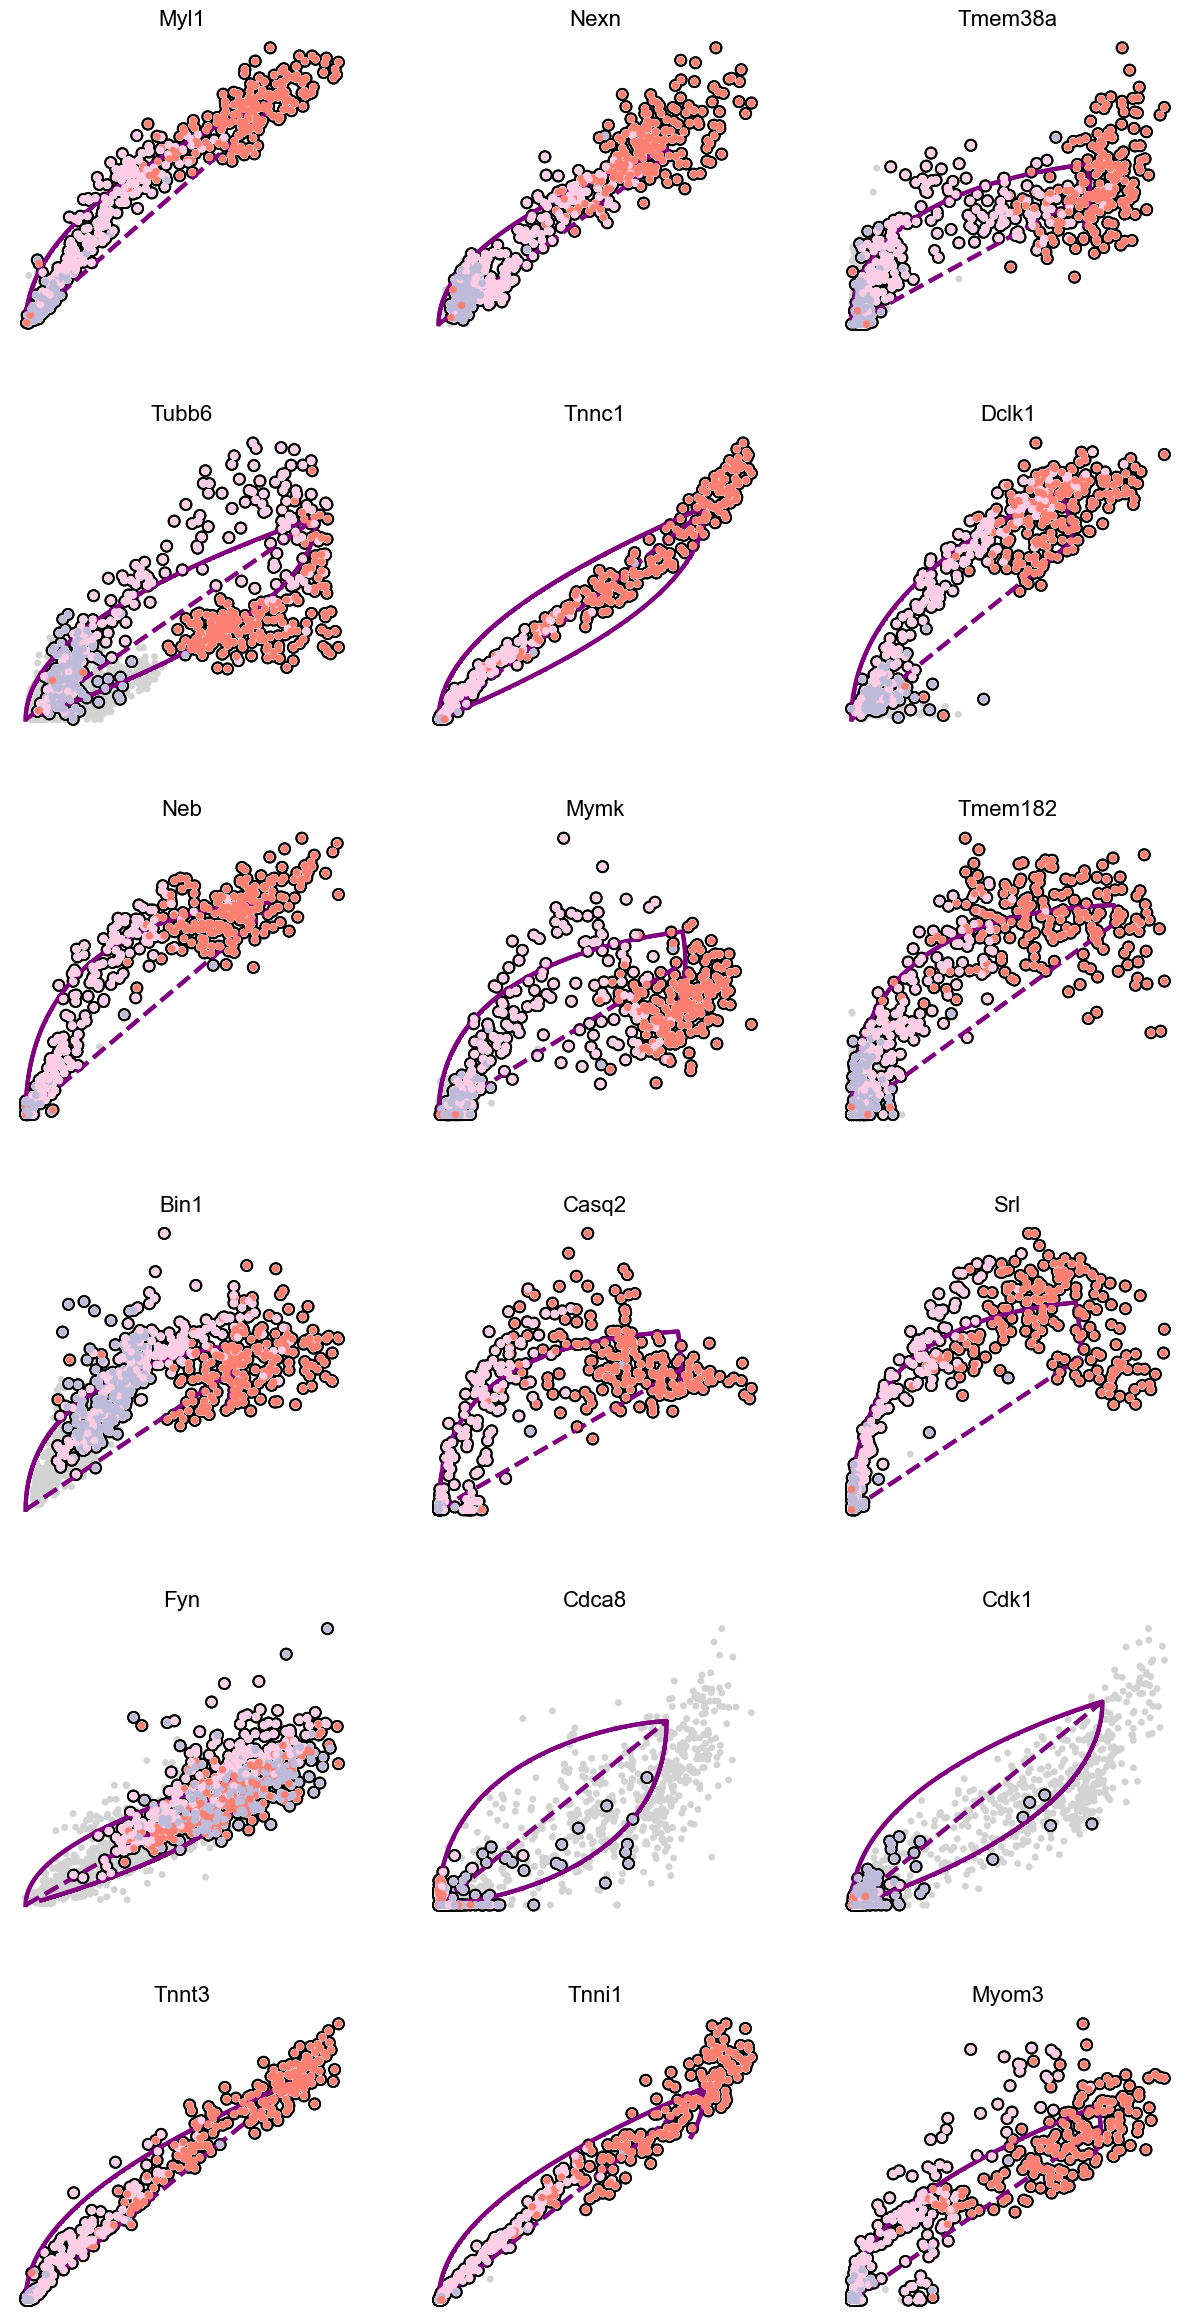

saving figure to file ./figures/scvelo_soft_8_1_bridge.png


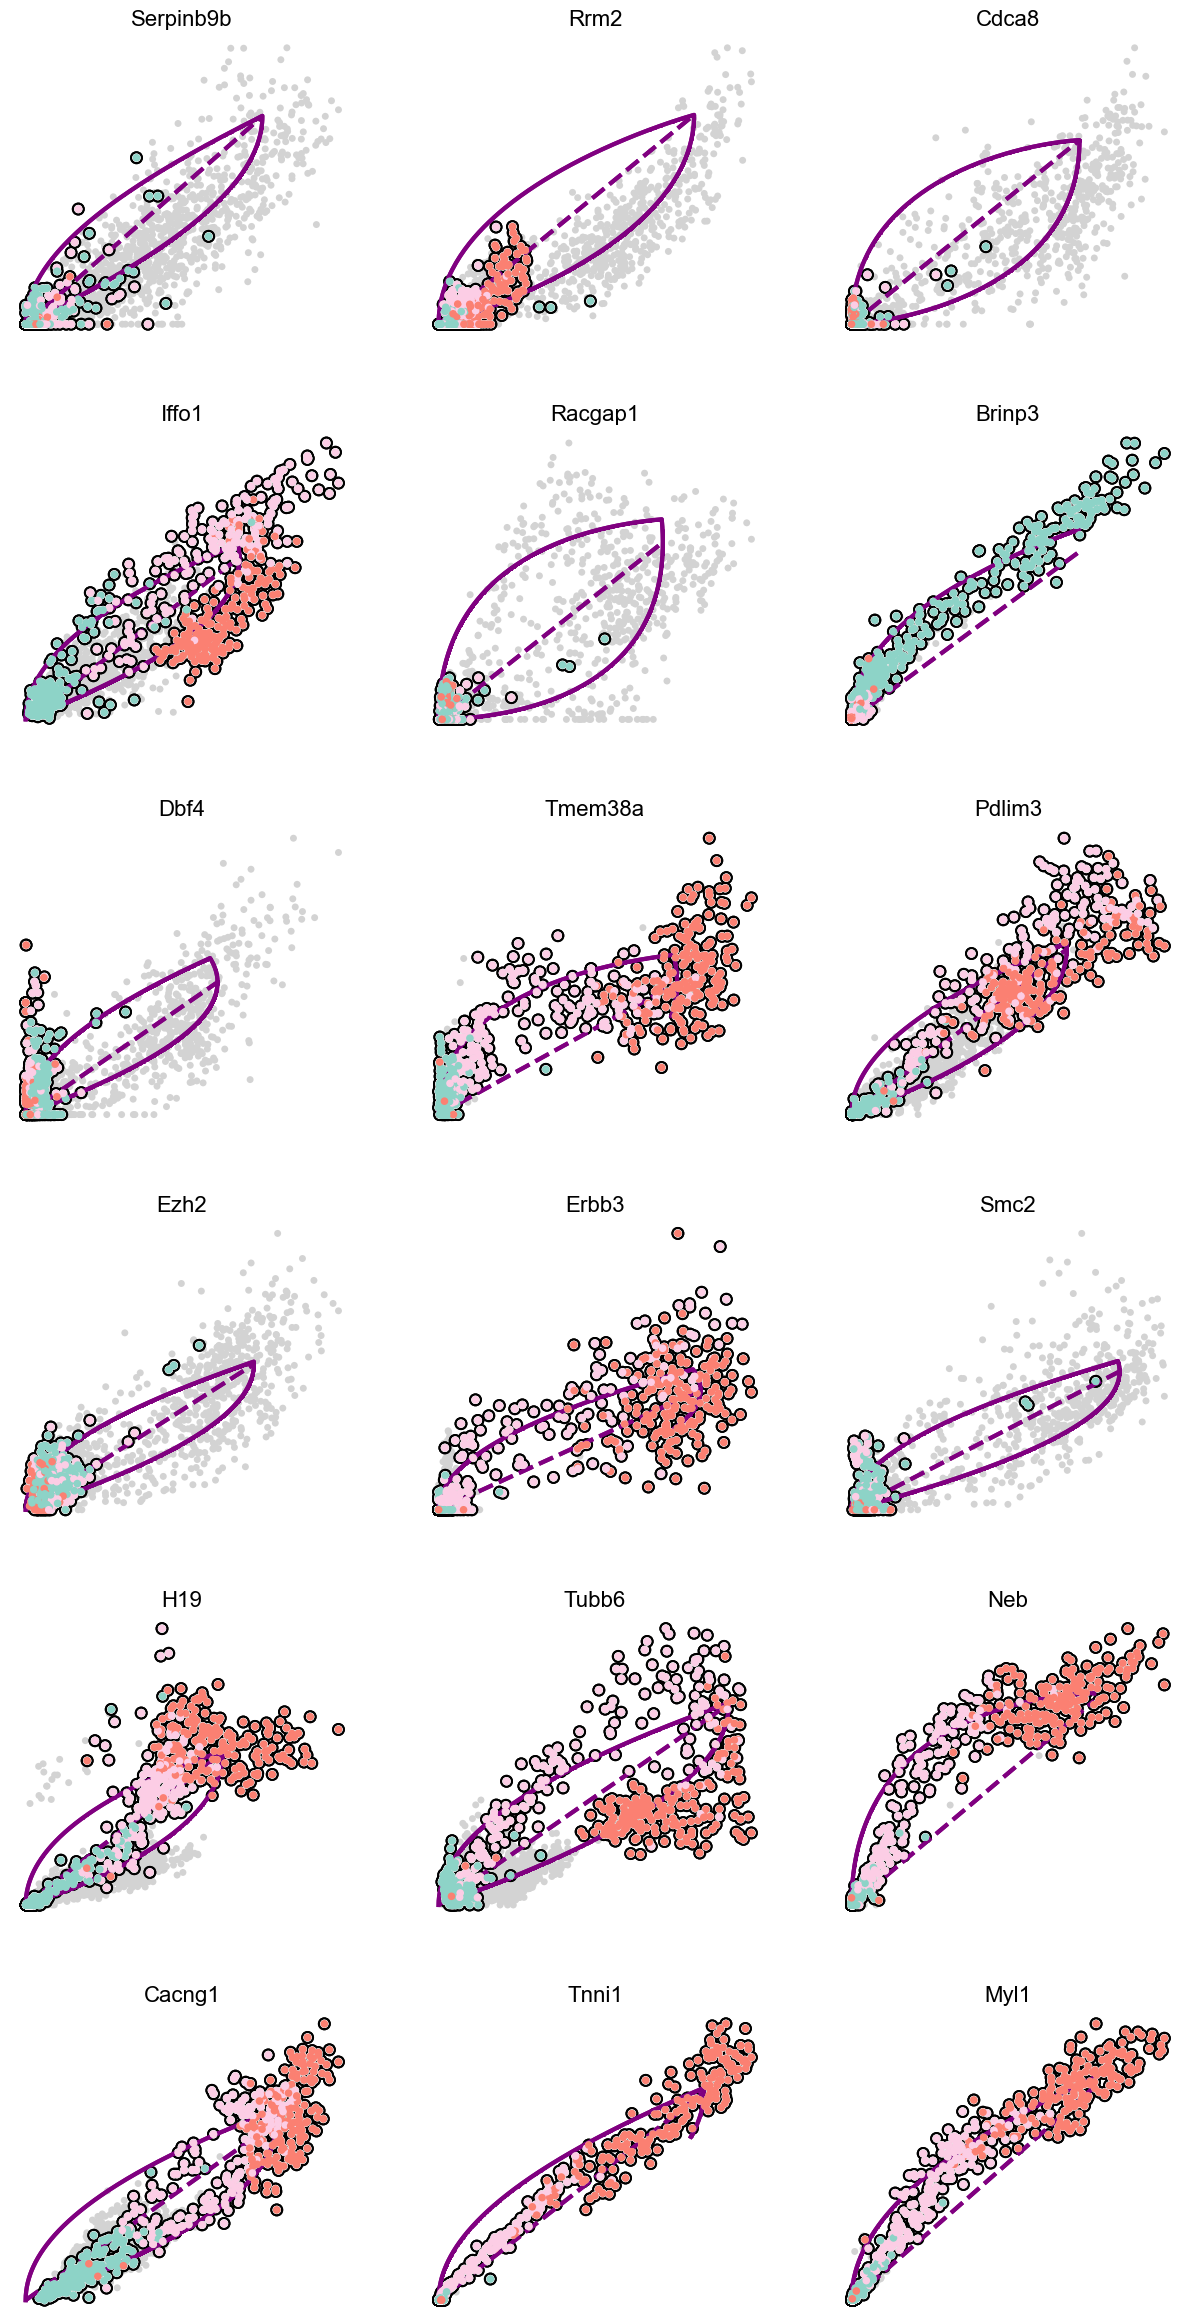

In [26]:
adata.obs["mesenchyme_bridge"]=adata.obs["clusters"].isin(["8","1"])
scv.tl.rank_velocity_genes(adata, groupby="mesenchyme_bridge",n_genes=18)
mesenchyme_bridge=pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
adata.obs["cycling_bridge"]=adata.obs["clusters"].isin(["8","3"])
scv.tl.rank_velocity_genes(adata, groupby="cycling_bridge",n_genes=18)
cycling_bridge=pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
scv.pl.scatter(adata, basis=cycling_bridge["True"].values.tolist(), fontsize=16, size=100, linewidth=3,color="clusters",
               frameon=False, figsize=[5,5],legend_loc='none',ncols=3,groups=["3","8","4"],add_outline='3, 8, 4',save="soft_8_3_bridge.png")

scv.pl.scatter(adata, basis=mesenchyme_bridge["True"].values.tolist(), fontsize=16, size=100, linewidth=3,color="clusters",
               frameon=False, figsize=[5,5],legend_loc='none',ncols=3,groups=["1","8","4"],add_outline='1, 8, 4',save="soft_8_1_bridge.png")

saving figure to file ./figures/scvelo_soft_8_3_bridge_markers.png


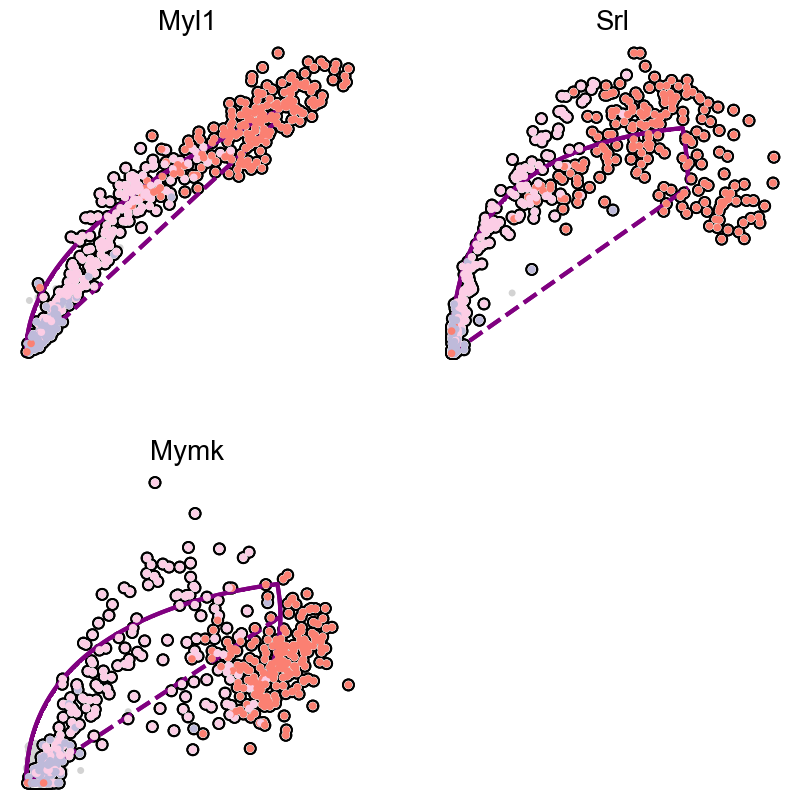

In [27]:
scv.pl.scatter(adata, basis=["Myl1","Srl","Mymk","Ryr1"], fontsize=20, size=100, linewidth=3,color="clusters",
               frameon=False, figsize=[5,5],legend_loc='none',ncols=2,groups=["3","8","4"],add_outline='3, 8,4',save="soft_8_3_bridge_markers.png")

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


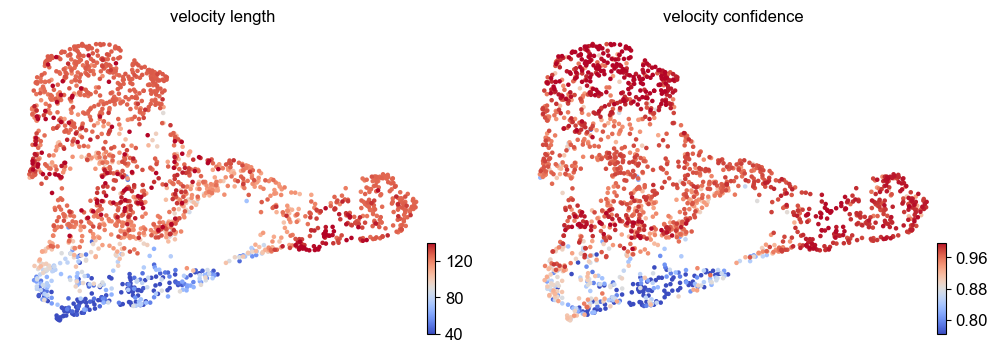

In [28]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata,basis="umap2", c=keys, cmap='coolwarm', perc=[5, 95])

In [29]:
adata.obs.mesenchyme_bridge=adata.obs.mesenchyme_bridge.astype(str)
adata.obs.cycling_bridge=adata.obs.cycling_bridge.astype(str)

In [30]:
adata.write_h5ad("adata_soft.h5ad")

/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


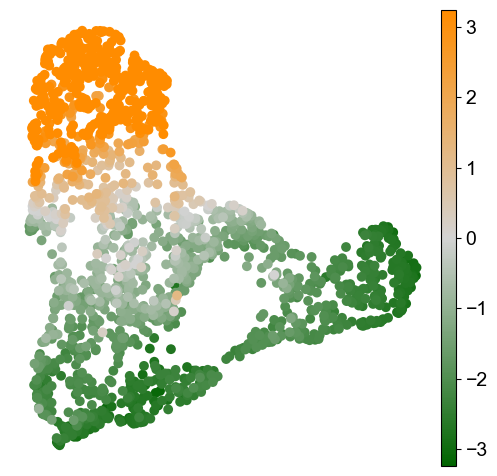

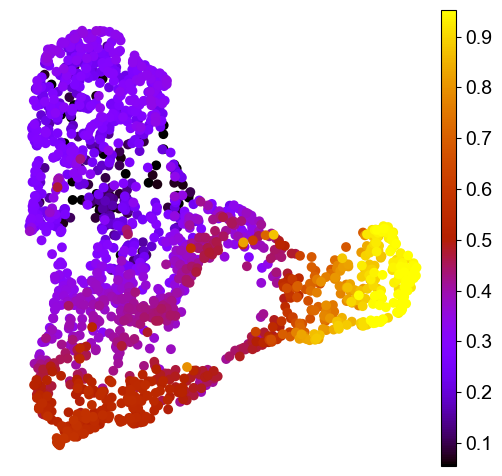

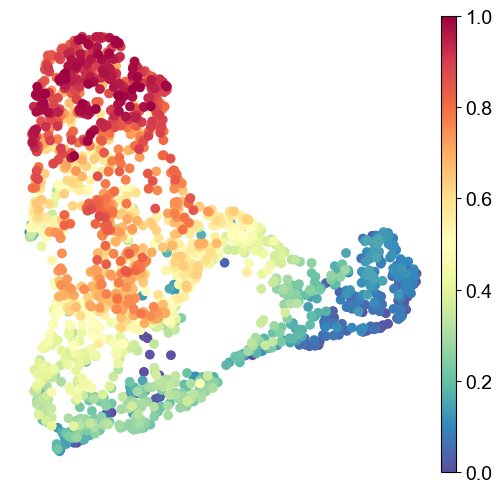

In [31]:
aspects=pd.read_csv("data/aspects_2_3.csv",index_col=0)
adata.obs["aspect"]=aspects.loc[adata.obs_names,"aspect3"]
adata.obs["CytoTRACE"]=pd.read_table("data/05pkaCytoTRACE_plot_table.txt")["CytoTRACE"]
from matplotlib.colors import LinearSegmentedColormap
cm=LinearSegmentedColormap.from_list("cm",["darkgreen","lightgrey","darkorange"])
import numpy as np
v=np.min([adata.obs.aspect.abs().max(),-adata.obs.aspect.min()])
adata.obsm["X_umap"]=adata.obsm["X_umap2"]
sc.set_figure_params(figsize=(6,6),dpi_save=600,dpi=50,frameon=False)
sc.pl.umap(adata,color="aspect",size=200,color_map=cm,vmin=-v,vmax=v,save="_soft_cc_aspect.png",title="")
sc.pl.umap(adata,color='latent_time', size=200,vmin="p2",vmax="p98", color_map='gnuplot',save="_soft_latent_time.png",title="")
sc.pl.umap(adata,color='CytoTRACE', size=200,color_map='Spectral_r',save="_soft_CytoTRACE.png",title="")